C:\Users\lenovo\AppData\Local\Temp\ipykernel_12684\2808221860.py:13: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])
C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 0, Generator Loss: 0.6861379146575928, Discriminator Loss: 1.3450989723205566
Epoch 100, Generator Loss: 0.6794760823249817, Discriminator Loss: 1.2809511423110962
Epoch 200, Generator Loss: 0.6738618612289429, Discriminator Loss: 1.4221599102020264
Epoch 300, Generator Loss: 0.6913120746612549, Discriminator Loss: 1.2840352058410645
Epoch 400, Generator Loss: 0.6264859437942505, Discriminator Loss: 1.3795113563537598
Epoch 500, Generator Loss: 0.710498571395874, Discriminator Loss: 1.3024232387542725
Epoch 600, Generator Loss: 0.717196524143219, Discriminator Loss: 1.1430308818817139
Epoch 700, Generator Loss: 0.7087453603744507, Discriminator Loss: 1.0728678703308105
Epoch 800, Generator Loss: 0.708116888999939, Discriminator Loss: 1.0354199409484863
Epoch 900, Generator Loss: 0.6597020626068115, Discriminator Loss: 1.4266473054885864
Entrenamiento completado


C:\Users\lenovo\AppData\Local\Temp\ipykernel_12684\2808221860.py:165: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


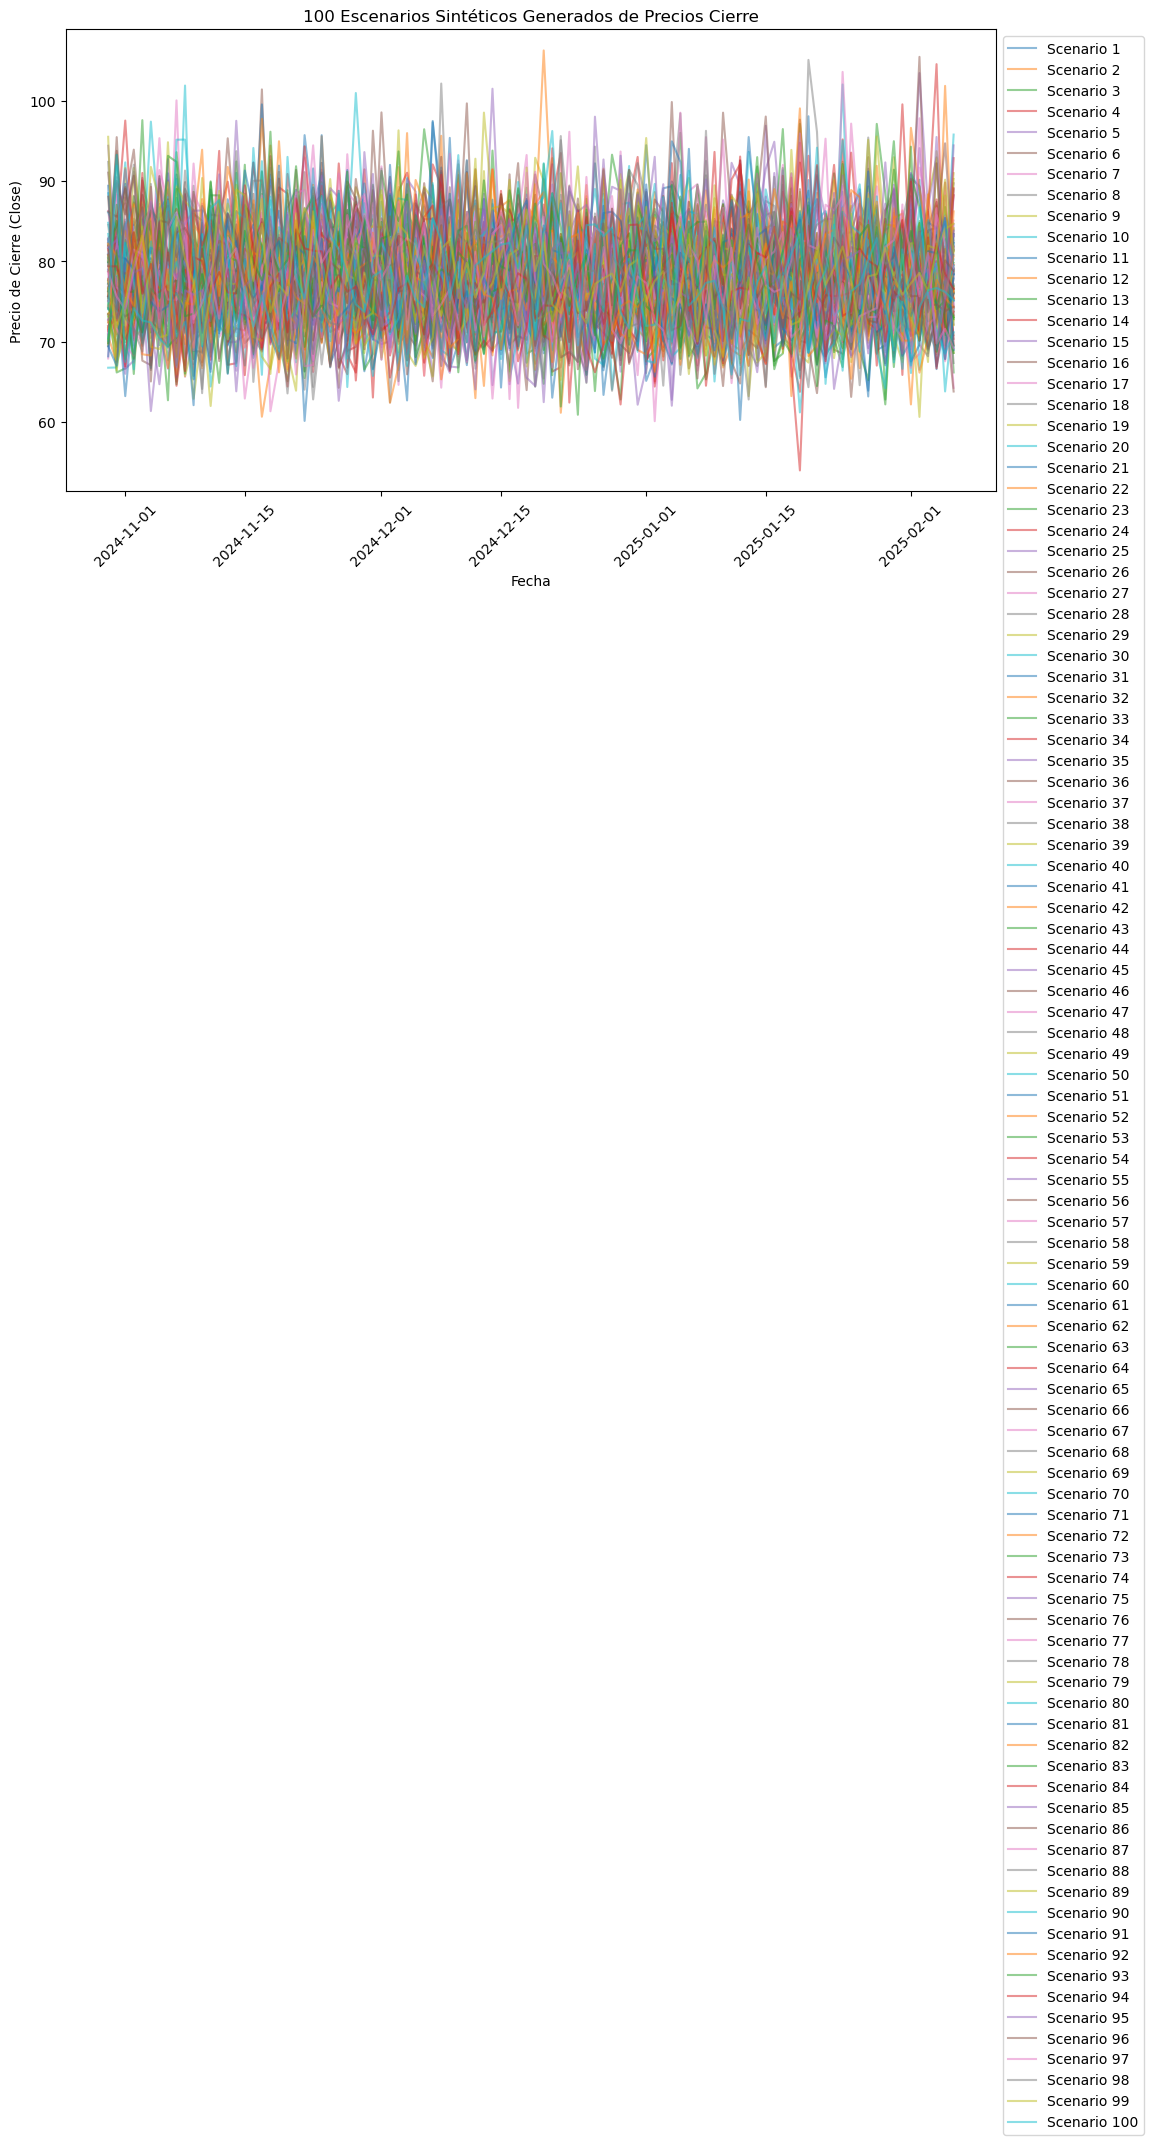

                        Date  Scenario_1  Scenario_2  Scenario_3  Scenario_4  \
0  2024-10-30 00:00:00-04:00   77.268822   70.902275   79.906593   71.504028   
1  2024-10-31 00:00:00-04:00   82.013306   74.193138   76.839127   78.752388   
2  2024-11-01 00:00:00-04:00   82.055687   76.653175   67.553108   79.611679   
3  2024-11-02 00:00:00-04:00   77.866638   75.449333   78.984154   81.539948   
4  2024-11-03 00:00:00-04:00   82.774521   85.351585   82.019585   88.222504   
..                       ...         ...         ...         ...         ...   
95 2025-02-02 00:00:00-04:00   79.589394   75.097992   84.765167   74.824577   
96 2025-02-03 00:00:00-04:00   76.756340   83.346069   74.564484   77.778610   
97 2025-02-04 00:00:00-04:00   78.045494   68.437386   70.722580   84.130562   
98 2025-02-05 00:00:00-04:00   77.818657   80.892677   86.759064   76.573967   
99 2025-02-06 00:00:00-04:00   75.001991   76.658028   73.044563   79.026367   

    Scenario_5  Scenario_6  Scenario_7 

In [47]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Paso 1: Cargar los datos desde el archivo CSV
df = pd.read_csv('aapl_data.csv')

# Paso 2: Preprocesamiento de los datos
# Convertir la columna 'Date' a tipo datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ordenar los datos por fecha (si no está ya ordenado)
df = df.sort_values('Date')

# Paso 3: Crear las características (X) y las etiquetas (y)
# Utilizamos las columnas 'Open', 'High', 'Low', 'Volume' y 'Close' del día anterior para predecir el 'Close' del día siguiente
X = df[['Open', 'High', 'Low', 'Volume', 'Close']].shift(1)  # Incluir 'Close' en X

# La etiqueta y será el valor de 'Close' del día siguiente
y = df['Close'].shift(-1)

# Eliminar las filas con NaN generadas por el shift
X = X.dropna()
y = y.dropna()

# Asegurarnos de que X y y tengan el mismo número de filas
X = X.iloc[:len(y)]  # Ajustar X para que tenga el mismo número de filas que y

# Paso 4: Normalizar las características (pero solo la entrada, no la salida)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X[['Open', 'High', 'Low', 'Volume']])  # Solo normalizamos las columnas de entrada

# Normalizar la columna 'Close' para la salida
close_scaler = MinMaxScaler()
close_scaler.fit(y.values.reshape(-1, 1))  # Ajustar el scaler de 'Close' con los datos originales

y_scaled = close_scaler.transform(y.values.reshape(-1, 1))  # Normalizamos la columna 'Close'

# Convertir las etiquetas y a un formato adecuado (son valores continuos)
y = y_scaled.flatten()

# Paso 5: Dividir los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Modelo del discriminador
def discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(4,)))  # Usamos 4 características (Open, High, Low, Volume)
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

# Modelo del generador
def generator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(100,)))  # Tamaño del ruido
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(4, activation='linear'))  # 4 salidas: Open, High, Low, Volume (sin Close aquí)
    return model

# Inicializar los modelos
gen_model = generator()
disc_model = discriminator()

# Funciones de pérdida
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Definir las funciones de pérdida
def generator_loss(y_fake):
    return loss_function(tf.ones_like(y_fake), y_fake)

def discriminator_loss(y_real, y_fake):
    real_loss = loss_function(tf.ones_like(y_real), y_real)
    fake_loss = loss_function(tf.zeros_like(y_fake), y_fake)
    return real_loss + fake_loss

# Paso 6: Entrenamiento
@tf.function
def train_step(images, batch_size=64):  # Reducimos el tamaño del batch para mayor estabilidad
    noise = tf.random.normal([batch_size, 100])  # Generar ruido aleatorio
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gen_model(noise, training=True)
        y_real = disc_model(images, training=True)
        y_fake = disc_model(generated_images, training=True)
        gen_loss = generator_loss(y_fake)
        disc_loss = discriminator_loss(y_real, y_fake)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, disc_model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, disc_model.trainable_variables))

    return gen_loss, disc_loss

# Número de escenarios a generar
num_scenarios = 100
num_days = 100  # Los próximos 100 días
num_epochs = 1000  # Ajusta el número de épocas según lo necesites

# Entrenamiento de la red
for epoch in range(num_epochs):
    # Entrenamiento por lotes
    for i in range(0, len(X_train), 64):
        batch_images = X_train[i:i + 64]
        gen_loss, disc_loss = train_step(batch_images)

    if epoch % 100 == 0:  # Cada 100 épocas muestra las pérdidas
        print(f'Epoch {epoch}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}')

print("Entrenamiento completado")

# Generar los 100 escenarios de precios sintéticos de 'Close' para los próximos 100 días
scenarios = []
for i in range(num_scenarios):
    # Generar 100 días de ruido aleatorio para obtener un escenario
    noise = tf.random.normal([num_days, 100])  # 100 días de ruido aleatorio
    generated_images = gen_model(noise, training=False)

    # Extraer las columnas generadas: 'Open', 'High', 'Low', 'Volume'
    generated_close = generated_images[:, 3]  # La columna 'Close' está en el índice 3 (0: Open, 1: High, 2: Low, 3: Close, 4: Volume)

    # Desnormalizar la columna 'Close' a la escala original
    generated_close = close_scaler.inverse_transform(generated_close.numpy().reshape(-1, 1)).flatten()

    # Guardar los precios de 'Close' generados para este escenario
    scenarios.append(generated_close)

# Convertir los escenarios generados a DataFrame
scenarios = np.array(scenarios)
scenarios_df = pd.DataFrame(scenarios.T, columns=[f"Scenario_{i+1}" for i in range(num_scenarios)])

# Generar fechas futuras para los 100 días
last_date = df['Date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_days, freq='D')

# Añadir la columna 'Date' con las fechas futuras
scenarios_df['Date'] = future_dates

# Paso 7: Graficar los 100 escenarios generados
plt.figure(figsize=(12, 6))

# Graficar los 100 escenarios generados de 'Close'
for i in range(num_scenarios):
    plt.plot(scenarios_df['Date'], scenarios_df[f"Scenario_{i+1}"], label=f"Scenario {i+1}", alpha=0.5)

# Etiquetas y título
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre (Close)")
plt.title("100 Escenarios Sintéticos Generados de Precios Cierre")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# Mostrar el DataFrame de los 100 escenarios generados (con fechas futuras)
print(scenarios_df[['Date'] + [f"Scenario_{i+1}" for i in range(num_scenarios)]])


C:\Users\lenovo\AppData\Local\Temp\ipykernel_12684\3773560947.py:111: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


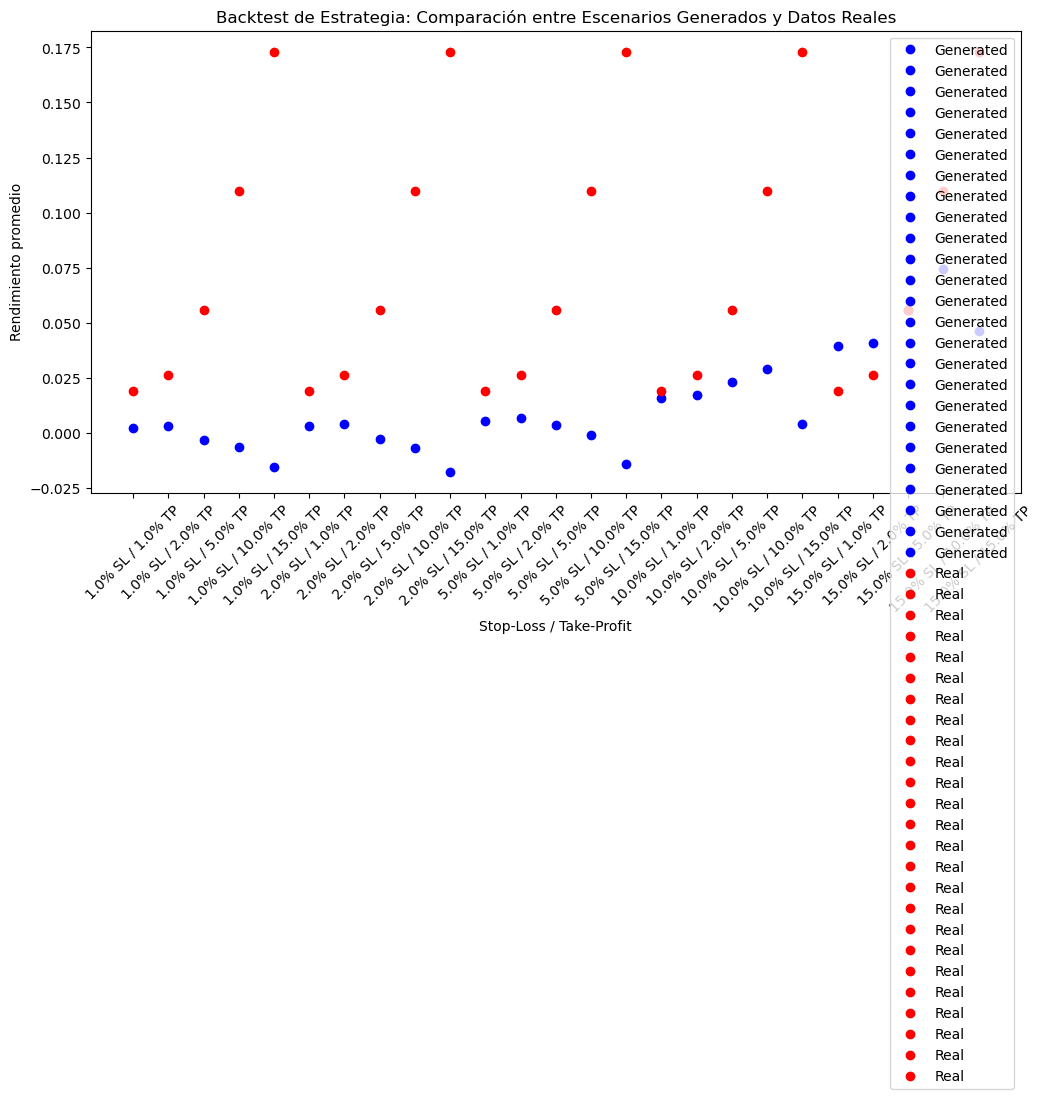

In [48]:
#Backtest
# Paso 1: Definir los parámetros de la estrategia de backtest
def backtest_strategy(scenario, initial_price, stop_loss_pct, take_profit_pct):
    """
    Simula una compra y venta en función de los niveles de stop-loss y take-profit.
    """
    stop_loss_price = initial_price * (1 - stop_loss_pct)  # Precio de stop-loss
    take_profit_price = initial_price * (1 + take_profit_pct)  # Precio de take-profit
    holding = False  # Indicador si estamos manteniendo una posición
    buy_price = 0

    # Recorrer el escenario para simular la compra y venta
    for i, price in enumerate(scenario):
        if not holding:
            # Realizamos la compra en el primer día
            holding = True
            buy_price = price  # Guardamos el precio de compra
            continue
        
        # Verificamos si se alcanzó el stop-loss o take-profit
        if price <= stop_loss_price:
            # Stop-loss alcanzado, vendemos
            return (price - buy_price) / buy_price  # Rentabilidad negativa
        elif price >= take_profit_price:
            # Take-profit alcanzado, vendemos
            return (price - buy_price) / buy_price  # Rentabilidad positiva

    # Si no se alcanza ni stop-loss ni take-profit, vendemos al último precio
    return (scenario[-1] - buy_price) / buy_price

# Paso 2: Evaluar el backtest para los 100 escenarios generados
def evaluate_backtest(scenarios_df, real_prices, stop_loss_levels, take_profit_levels):
    """
    Evalúa el backtest para diferentes niveles de stop-loss y take-profit.
    """
    results = []  # Almacenar los resultados para cada escenario y cada nivel de SL/TP
    num_scenarios = len(scenarios_df)  # Número de escenarios generados

    # Evaluar para cada nivel de stop-loss y take-profit
    for stop_loss_pct in stop_loss_levels:
        for take_profit_pct in take_profit_levels:
            scenario_results = []  # Almacenar resultados de todos los escenarios para un SL/TP
            for i in range(num_scenarios):
                scenario = scenarios_df.iloc[i, :-1].values  # Obtenemos el escenario de precios 'Close' (sin la columna 'Date')
                initial_price = scenario[0]  # Precio de compra en el primer día del escenario

                # Realizar el backtest para este escenario
                performance = backtest_strategy(scenario, initial_price, stop_loss_pct, take_profit_pct)
                scenario_results.append(performance)

            # Almacenar los resultados medios para este par de stop-loss y take-profit
            results.append({
                'Stop-Loss': stop_loss_pct,
                'Take-Profit': take_profit_pct,
                'Average Performance': np.mean(scenario_results)
            })

    # Convertir los resultados a un DataFrame para visualización
    results_df = pd.DataFrame(results)
    return results_df

# Paso 3: Configuración de los niveles de stop-loss y take-profit
stop_loss_levels = [0.01, 0.02, 0.05, 0.1, 0.15]  # Niveles de stop-loss (1%, 2%, 5%, 10%, 15%)
take_profit_levels = [0.01, 0.02, 0.05, 0.1, 0.15]  # Niveles de take-profit (1%, 2%, 5%, 10%, 15%)

# Paso 4: Evaluación con los 100 escenarios generados y los datos reales
# En este caso, asumimos que 'scenarios_df' es el DataFrame con los 100 escenarios generados
# y 'df' contiene los datos históricos reales de los precios de las acciones (con la columna 'Close')

# Obtener el rendimiento de los escenarios generados
results_generated = evaluate_backtest(scenarios_df, df['Close'], stop_loss_levels, take_profit_levels)

# Evaluar el rendimiento de la estrategia con los datos reales (para comparar)
real_results = []
for stop_loss_pct in stop_loss_levels:
    for take_profit_pct in take_profit_levels:
        performance = backtest_strategy(df['Close'].values, df['Close'].iloc[0], stop_loss_pct, take_profit_pct)
        real_results.append({
            'Stop-Loss': stop_loss_pct,
            'Take-Profit': take_profit_pct,
            'Average Performance': performance
        })

# Convertir los resultados reales a un DataFrame
real_results_df = pd.DataFrame(real_results)

# Paso 5: Visualización de los resultados

# Graficar la comparación entre los escenarios generados y los datos reales
plt.figure(figsize=(12, 6))

# Graficar los resultados de los escenarios generados
for stop_loss_pct in stop_loss_levels:
    for take_profit_pct in take_profit_levels:
        avg_perf_gen = results_generated[(results_generated['Stop-Loss'] == stop_loss_pct) & 
                                         (results_generated['Take-Profit'] == take_profit_pct)]['Average Performance'].values[0]
        plt.plot(f"{stop_loss_pct*100}% SL / {take_profit_pct*100}% TP", avg_perf_gen, 'bo', label="Generated")

# Graficar los resultados de los datos reales
for stop_loss_pct in stop_loss_levels:
    for take_profit_pct in take_profit_levels:
        avg_perf_real = real_results_df[(real_results_df['Stop-Loss'] == stop_loss_pct) & 
                                        (real_results_df['Take-Profit'] == take_profit_pct)]['Average Performance'].values[0]
        plt.plot(f"{stop_loss_pct*100}% SL / {take_profit_pct*100}% TP", avg_perf_real, 'ro', label="Real")

plt.xlabel("Stop-Loss / Take-Profit")
plt.ylabel("Rendimiento promedio")
plt.title("Backtest de Estrategia: Comparación entre Escenarios Generados y Datos Reales")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


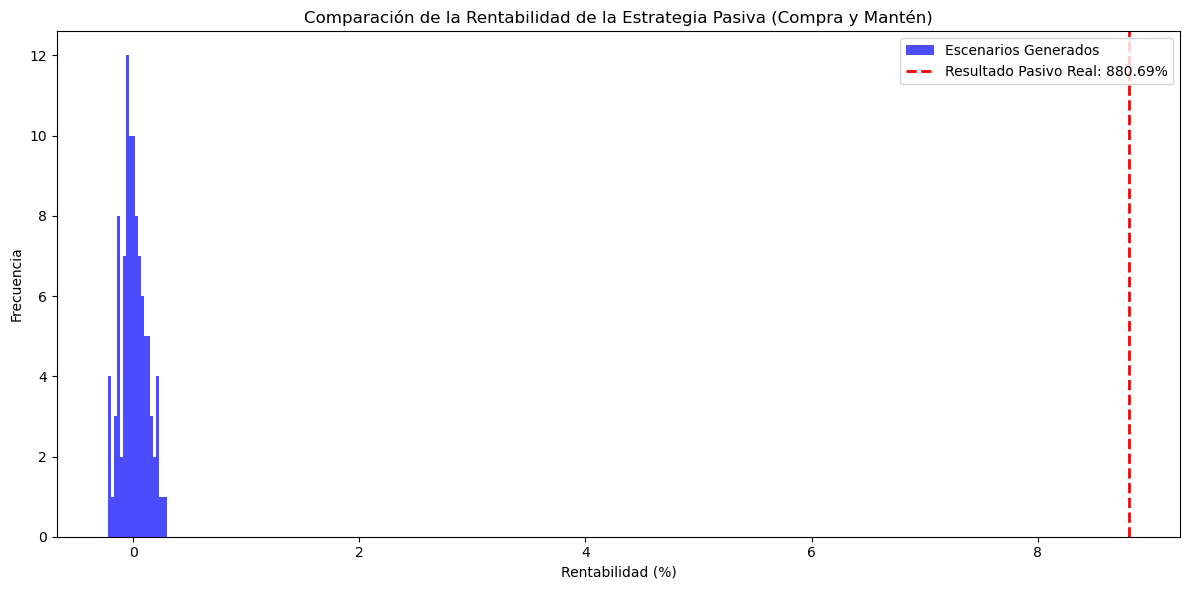

Rendimiento de la Estrategia Pasiva con los datos reales: 880.69%


In [49]:
#Estrategia pasiva

# Paso 1: Definir la estrategia pasiva
def passive_strategy(scenario, initial_price):
    """
    Implementa la estrategia pasiva: compra en el primer día y mantiene hasta el final.
    """
    final_price = scenario[-1]  # Precio final al final del periodo
    performance = (final_price - initial_price) / initial_price  # Rentabilidad
    return performance

# Paso 2: Evaluar la estrategia pasiva con los 100 escenarios generados
def evaluate_passive_backtest(scenarios_df, real_prices):
    """
    Evalúa el rendimiento de la estrategia pasiva en los escenarios generados y en los datos reales.
    """
    passive_results = []  # Almacenar resultados de la estrategia pasiva
    num_scenarios = len(scenarios_df)  # Número de escenarios generados

    # Evaluar para los 100 escenarios generados
    for i in range(num_scenarios):
        scenario = scenarios_df.iloc[i, :-1].values  # Obtenemos el escenario de precios 'Close'
        initial_price = scenario[0]  # Precio de compra en el primer día del escenario

        # Realizar el backtest pasivo para este escenario
        performance = passive_strategy(scenario, initial_price)
        passive_results.append(performance)

    # Evaluar el rendimiento de la estrategia pasiva con los datos reales
    initial_price_real = real_prices.iloc[0]  # Precio de compra en el primer día de los datos reales
    performance_real = passive_strategy(real_prices.values, initial_price_real)

    return passive_results, performance_real

# Paso 3: Configuración de los datos para backtest
# 'scenarios_df' es el DataFrame con los 100 escenarios generados
# 'df' contiene los datos históricos reales de los precios de las acciones (con la columna 'Close')

# Evaluar la estrategia pasiva con los 100 escenarios generados y los datos reales
passive_results, performance_real = evaluate_passive_backtest(scenarios_df, df['Close'])

# Paso 4: Comparación de los resultados

# Graficar la comparación entre los escenarios generados y la estrategia pasiva
plt.figure(figsize=(12, 6))

# Graficar los resultados de los escenarios generados con la estrategia pasiva
plt.hist(passive_results, bins=20, alpha=0.7, label='Escenarios Generados', color='b')

# Graficar el resultado de la estrategia pasiva con los datos reales
plt.axvline(performance_real, color='r', linestyle='dashed', linewidth=2, label=f'Resultado Pasivo Real: {performance_real*100:.2f}%')

# Etiquetas y título
plt.xlabel("Rentabilidad (%)")
plt.ylabel("Frecuencia")
plt.title("Comparación de la Rentabilidad de la Estrategia Pasiva (Compra y Mantén)")
plt.legend(loc='upper right')
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# Paso 5: Imprimir el rendimiento de la estrategia pasiva con los datos reales
print(f"Rendimiento de la Estrategia Pasiva con los datos reales: {performance_real * 100:.2f}%")


Indicadores Financieros para los Escenarios Generados y Datos Reales:
     Sharpe Ratio  Max Drawdown  Calmar Ratio         P&L  Win-Loss Ratio
0        0.052834     -0.277846     -0.022300   -3.234917        1.062500
1        0.068048     -0.304446     -0.027825    9.894936        0.867925
2        0.039424     -0.315281     -0.014467  -14.580170        0.767857
3        0.049340     -0.291275     -0.018553   -3.698547        0.903846
4        0.039002     -0.298853     -0.013777  -10.144623        1.062500
..            ...           ...           ...         ...             ...
96       0.046093     -0.232272     -0.018913   -0.361603        0.941176
97       0.052341     -0.362284     -0.015744   -1.371422        1.062500
98       0.052600     -0.373605     -0.015726   -1.631691        1.106383
99       0.055298     -0.334018     -0.018833    0.134315        0.980000
100      0.059528     -0.385159     -0.002776  209.843008        1.131579

[101 rows x 5 columns]


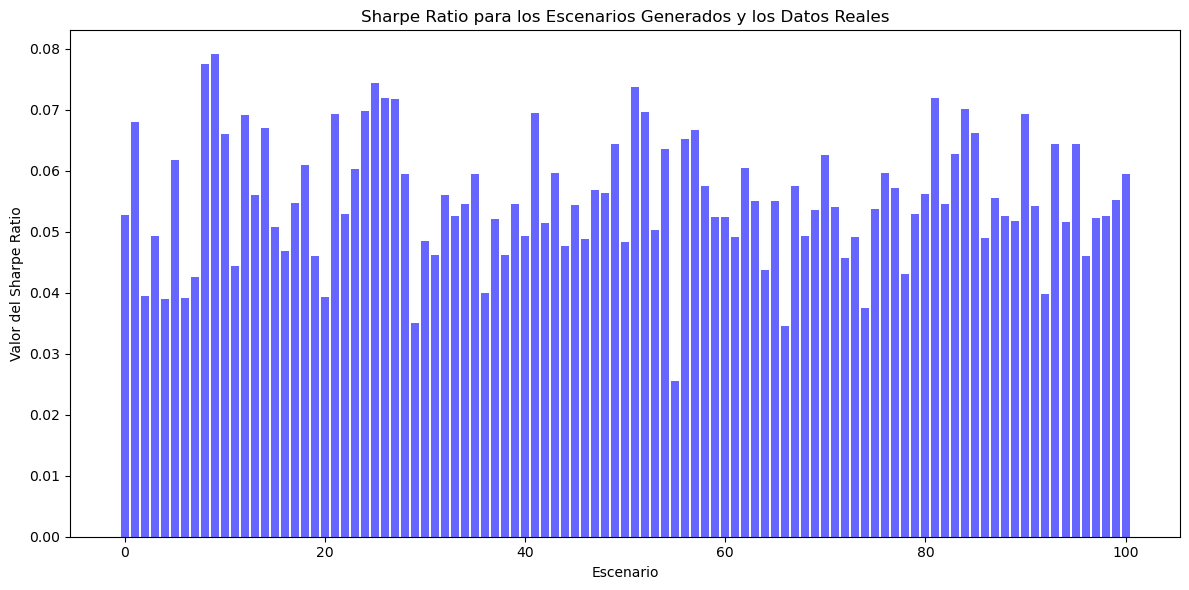

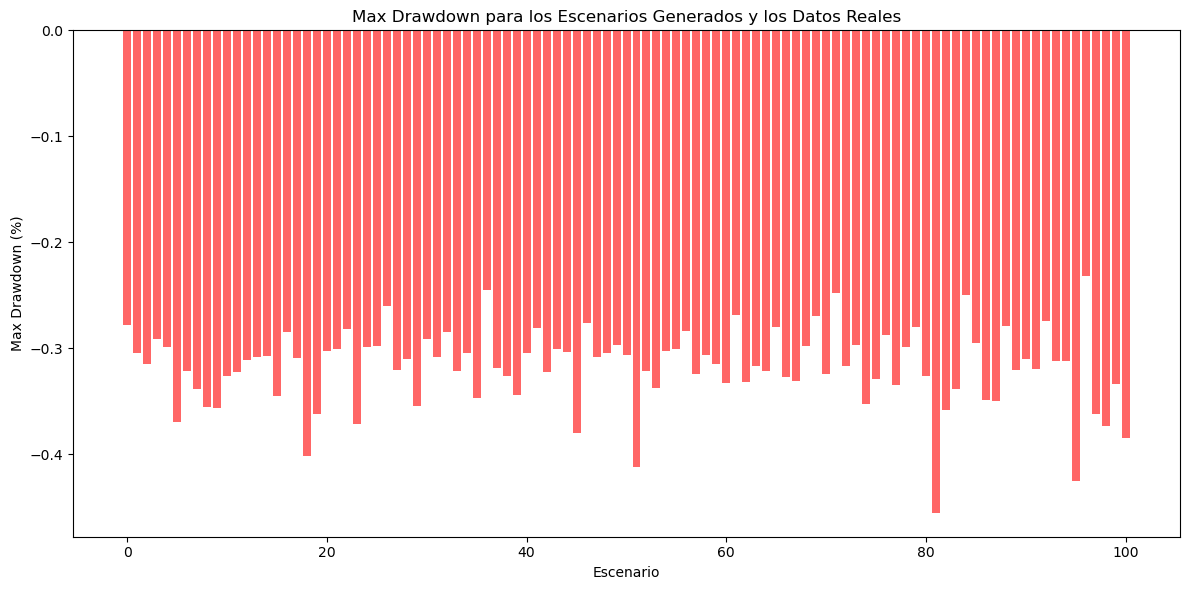

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Función para calcular el rendimiento diario de una serie de precios
def daily_returns(prices):
    prices_series = pd.Series(prices)  # Convertir a pandas Series
    returns = prices_series.pct_change().dropna()  # Calculamos los retornos diarios (porcentaje de cambio)
    return returns

# Función para calcular el Sharpe Ratio
def sharpe_ratio(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate  # Rentabilidad ajustada por la tasa libre de riesgo
    return excess_returns.mean() / excess_returns.std()  # Rentabilidad media / desviación estándar

# Función para calcular el Calmar Ratio
def calmar_ratio(returns, max_drawdown):
    return returns.mean() / max_drawdown

# Función para calcular el Max Drawdown
def max_drawdown(prices):
    prices_series = pd.Series(prices)  # Convertir a pandas Series
    cumulative_returns = (1 + daily_returns(prices)).cumprod()  # Rentabilidad acumulada
    running_max = np.maximum.accumulate(cumulative_returns)  # Máximo acumulado
    drawdown = (cumulative_returns - running_max) / running_max  # Drawdown
    max_drawdown = drawdown.min()  # El mayor drawdown es el mínimo valor de esta serie
    return max_drawdown

# Función para calcular el Profit & Loss (P&L)
def profit_loss(initial_price, final_price):
    return final_price - initial_price

# Función para calcular el Win-Loss Ratio
def win_loss_ratio(trades):
    wins = sum(1 for x in trades if x > 0)  # Contamos las ganancias
    losses = sum(1 for x in trades if x < 0)  # Contamos las pérdidas
    return wins / losses if losses != 0 else float('inf')  # Proporción ganadora/perdedora

# Función para realizar el backtest en el caso de los escenarios generados
def backtest_scenarios(scenarios_df, real_prices):
    # Eliminar la columna "Date" de scenarios_df
    scenarios_df = scenarios_df.drop(columns=['Date'])
    
    # Almacenamos los rendimientos y las operaciones para cada escenario
    results = []
    all_trades = []
    
    # Evaluar el rendimiento de la estrategia pasiva para cada escenario
    for i, scenario in scenarios_df.iterrows():
        # Asegurarse de que 'scenario' es una Serie de pandas (en lugar de ndarray)
        scenario_prices = scenario.values  # Solo los precios de cierre (valores numéricos)
        
        initial_price = scenario_prices[0]  # Obtener el primer precio
        final_price = scenario_prices[-1]   # Obtener el último precio
        
        # Calcular rendimientos diarios
        returns = daily_returns(scenario_prices)  
        
        # Calcular indicadores financieros
        sharpe = sharpe_ratio(returns)
        max_dd = max_drawdown(scenario_prices)
        calmar = calmar_ratio(returns, max_dd)
        pnl = profit_loss(initial_price, final_price)
        
        # Simulamos operaciones (simples ganancias/perdidas)
        trades = np.diff(scenario_prices)  # Las diferencias entre días nos dan las ganancias o pérdidas diarias
        all_trades.extend(trades)  # Almacenamos todas las operaciones
        
        results.append({
            'Sharpe Ratio': sharpe,
            'Max Drawdown': max_dd,
            'Calmar Ratio': calmar,
            'P&L': pnl,
            'Win-Loss Ratio': win_loss_ratio(trades)
        })

    # Evaluar el rendimiento de los datos reales
    real_prices_values = real_prices.values  # Asegurarse de que sea solo una serie numérica (precios de cierre)
    initial_price_real = real_prices_values[0]
    final_price_real = real_prices_values[-1]
    returns_real = daily_returns(real_prices_values)
    sharpe_real = sharpe_ratio(returns_real)
    max_dd_real = max_drawdown(real_prices_values)
    calmar_real = calmar_ratio(returns_real, max_dd_real)
    pnl_real = profit_loss(initial_price_real, final_price_real)
    
    # Simulamos operaciones en los datos reales
    trades_real = np.diff(real_prices_values)  # Las diferencias entre días nos dan las ganancias o pérdidas diarias
    win_loss_real = win_loss_ratio(trades_real)
    
    results.append({
        'Sharpe Ratio': sharpe_real,
        'Max Drawdown': max_dd_real,
        'Calmar Ratio': calmar_real,
        'P&L': pnl_real,
        'Win-Loss Ratio': win_loss_real
    })

    return pd.DataFrame(results)

# Paso 2: Llamar a la función para calcular indicadores financieros de los escenarios y los datos reales
# Aquí asumimos que 'scenarios_df' es el DataFrame de escenarios generados y 'df' contiene los datos reales

# Asegúrate de que 'df' tiene la columna 'Close' con los precios reales
financial_indicators = backtest_scenarios(scenarios_df, df['Close'])

# Paso 3: Imprimir los indicadores financieros
print("Indicadores Financieros para los Escenarios Generados y Datos Reales:")
print(financial_indicators)

# Paso 4: Graficar algunos de los indicadores financieros
plt.figure(figsize=(12, 6))
plt.bar(financial_indicators.index, financial_indicators['Sharpe Ratio'], color='b', alpha=0.6, label="Sharpe Ratio")
plt.xlabel("Escenario")
plt.ylabel("Valor del Sharpe Ratio")
plt.title("Sharpe Ratio para los Escenarios Generados y los Datos Reales")
plt.tight_layout()
plt.show()

# Graficar el Max Drawdown
plt.figure(figsize=(12, 6))
plt.bar(financial_indicators.index, financial_indicators['Max Drawdown'], color='r', alpha=0.6, label="Max Drawdown")
plt.xlabel("Escenario")
plt.ylabel("Max Drawdown (%)")
plt.title("Max Drawdown para los Escenarios Generados y los Datos Reales")
plt.tight_layout()
plt.show()
